# COVID-Symptom Facebook Survey

In [ ]:
# Install packages locally
#!pip3 install --install-option="--prefix=$HOME/local" packagename

In [37]:
import numpy as np
import pandas as pd
import os
import re
import datetime as dt
import matplotlib.pyplot as plt
import plotnine as p9
# Load all the locally installed packages
%cd /export/home/honlee/local/lib64/python3.6/site-packages
import sqlalchemy as sqla
import pymongo
%cd ../../../../
from loadEngine import *
%matplotlib inline

/export/home/honlee/local/lib64/python3.6/site-packages
/export/home/honlee


In [23]:
# Read the questions to keep track what we are looking at
question = pd.read_csv("data/question.csv")

## Get all the monthly files ({YYYY}-{MM}.csv.gz) and put them into a .sqlite file

In [3]:
# Check if a file exists, it so, we load it directly
# if not, we will make an engine for querying the data
engine = loadEngine("data/survey.sqlite")

## Total number of samples from all monthly files

In [4]:
query = """select count(*) as num_of_observations from survey"""
num_row = pd.read_sql_query(query, engine)
num_row

,num_of_observations
0,15419328


## Show all column names

In [5]:
# Get a quick view on the data
query = """select * from survey limit 1"""
df = pd.read_sql_query(query, engine)
print(" ".join(df))
df

index StartDatetime EndDatetime A1_1 A1_2 A1_3 A1_4 A1_5 A2 A2b A3 A3b A4 B2 B2_14_TEXT B2b B3 B4 B5 B6 C1 C2 C3 C4 C5 C6 C7 C8_1 C8_2 C9 C10_1_1 C10_2_1 C10_3_1 C10_4_1 C11 C12 D1 D1_4_TEXT D1b D2 D3 D4 D5 Q36 Q40 wave UserLanguage fips weight A5_1 A5_2 A5_3 B2c B2c_14_TEXT B7 B8 B10 B10a B10b B12 B12a B11 C8_3 C13 C13a C14 C15 D8 D9 Q64 Q65 Q66 Q67 Q68 Q69 Q70 Q71 Q72 Q73 Q74 Q75 Q76 Q77 Q78 Q79 Q80 D10 C16 C17 E3 E1_1 E1_2 E1_3 E1_4 E2_1 E2_2 V1 V2 V3 V4_1 V4_2 V4_3 V4_4 V4_5 V9


,index,StartDatetime,EndDatetime,A1_1,A1_2,A1_3,A1_4,A1_5,A2,A2b,...,E2_2,V1,V2,V3,V4_1,V4_2,V4_3,V4_4,V4_5,V9
0,0,2020-04-06,2020-04-06,2.0,2.0,2.0,2.0,2.0,None,6.0,...,None,None,None,None,None,None,None,None,None,None


## Number of reponses by wave

We can see that we have only up to 7 waves and most responses come from wave 3 (May 21 2020- September 7 2020)

In [20]:
# Get a quick view on the data
query = """select wave, count(*) as num_of_responses from survey GROUP BY wave"""
view = pd.read_sql_query(query, engine)
view

,wave,count(*)
0,1,100017
1,2,1547986
2,3,7334889
3,4,2966381
4,5,1274141
5,6,1246934
6,7,948980


## The overall number of responses by zipcode

The result shows that zipcode is not quite reliable since it contains various forms.

In [21]:
# Get a quick view on the data
query = """
    SELECT A3 as zipcode, COUNT(*) as num_of_responses 
    FROM survey
    GROUP BY A3 
"""
view = pd.read_sql_query(query, engine)
view

,zipcode,num_of_responses
0,None,229448
1,0.0,721
2,00000,2253
3,00000-1111,1
4,00001,82
...,...,...
137513,99996,2
137514,99998,3
137515,99999,277
137516,99999-9999,1


## Number of vaccinations by states

V1: Have you had a COVID-19 vaccination?

In [171]:
# Get a quick view on the data
query = """
    SELECT a.state_name, s.num_of_yes
    FROM (SELECT A3b as State, COUNT(*) as num_of_yes
    FROM survey 
    WHERE wave >= 6 AND V1 = 1.0 AND State != "NaN"
    GROUP BY A3b, V1) s 
    INNER JOIN area a 
    WHERE s.State = a.state_id
    ORDER BY s.num_of_yes ASC;
"""
view = pd.read_sql_query(query, engine)

In [179]:
# add percentage
view["percentage"] = round(view["num_of_yes"] / np.sum(view["num_of_yes"])*100,2)

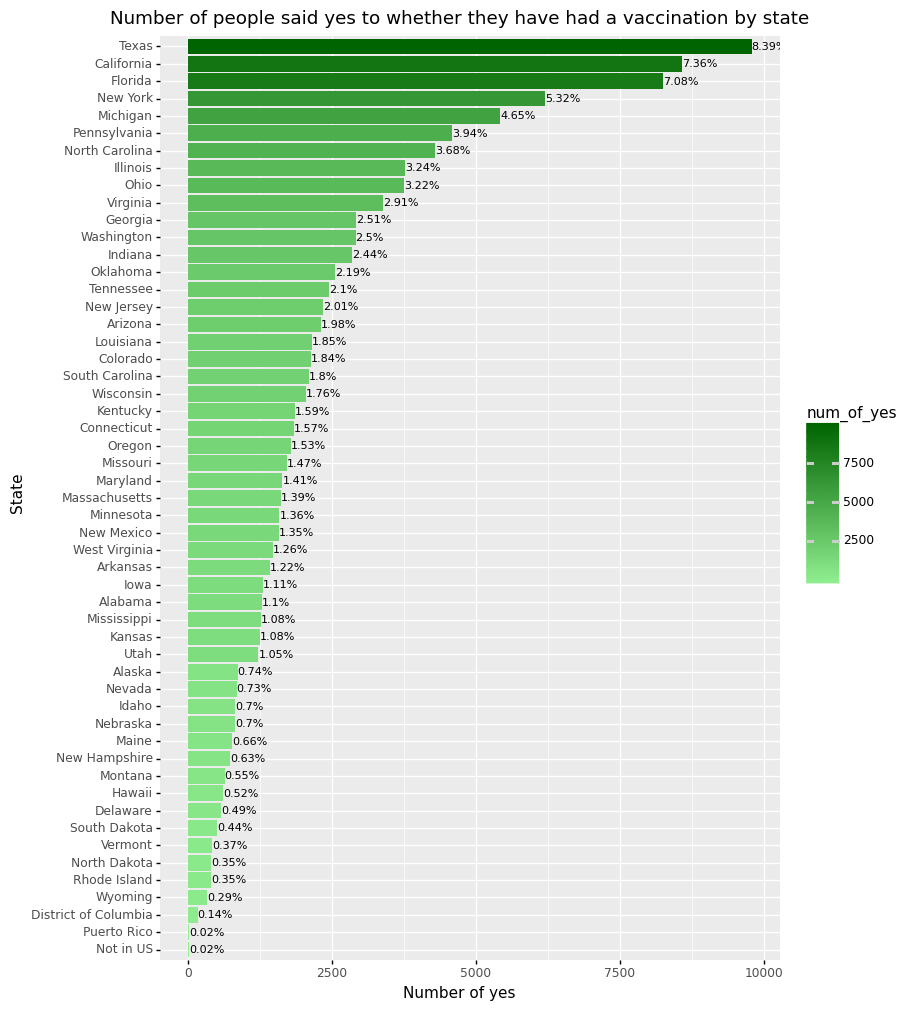

<ggplot: (-9223363284976543968)>

In [202]:
# Plot a bar chart
dodge_text = p9.position_dodge(width=0.9)

(p9.ggplot(view, p9.aes(x='reorder(state_name, num_of_yes)', y='num_of_yes', fill='num_of_yes')) 
 + p9.geom_bar(stat = "identity", position='dodge')
 + p9.coord_flip()
 + p9.geom_text(p9.aes(label='percentage'),                                   
             position=dodge_text,
             size=8, ha='left', format_string='{}%')
 + p9.scale_fill_gradient(low="lightgreen",high="darkgreen")
 + p9.labs(y='Number of yes', x='State', title='Number of people said yes to whether they have had a vaccination by state')
 + p9.theme(figure_size=(8, 12))
)

## Filter the number of yes by the age group

* 18-24 years (1)
* 25-34 years (2)
* 35-44 years (3)
* 45-54 years (4)
* 55-64 years (5)
* 65-74 years (6)
* 75 years or older (7) 

In [204]:
# Get a quick view on the data
query = """
    SELECT a.state_name, s.age , s.num_of_yes
    FROM (SELECT A3b as State, D2 as age, COUNT(*) as num_of_yes
    FROM survey 
    WHERE wave >= 6 AND V1 = 1.0 AND State != "NaN" AND D2 != "NaN"
    GROUP BY A3b, D2) s 
    INNER JOIN area a 
    WHERE s.State = a.state_id
    ORDER BY s.num_of_yes ASC;
"""
view = pd.read_sql_query(query, engine)

In [213]:
# Cast the float to str
view["age"]= view["age"].astype(int).astype(str)

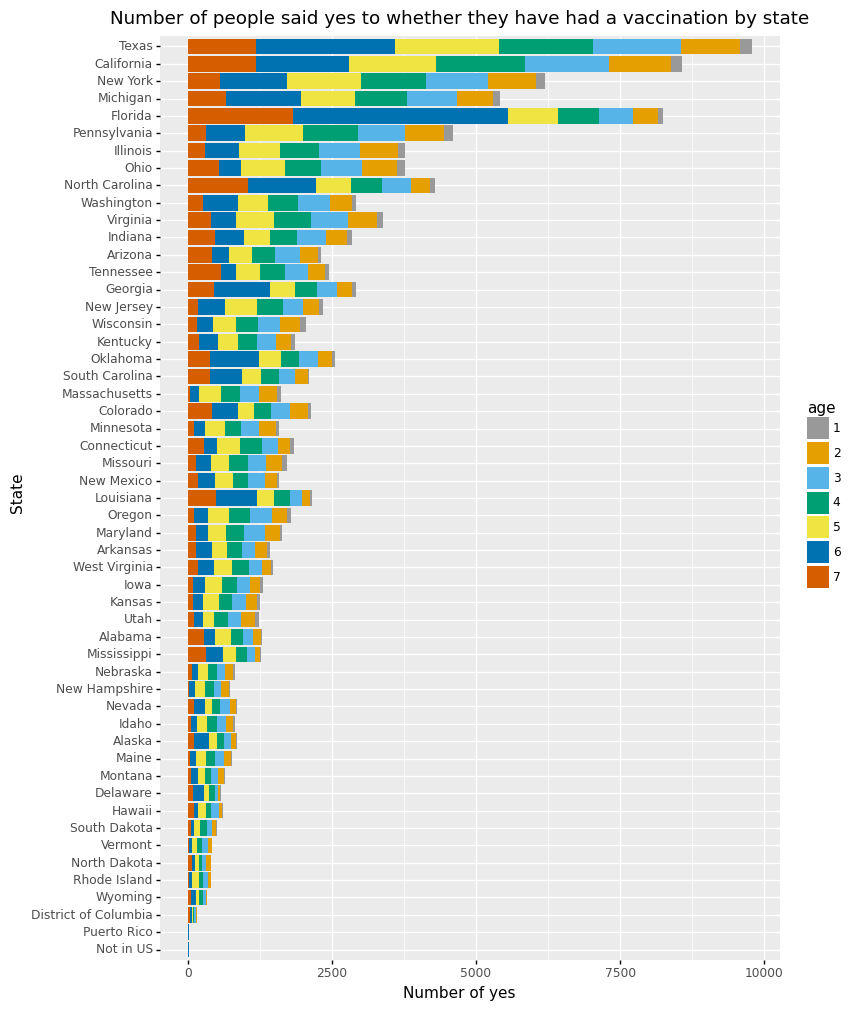

<ggplot: (8751878138702)>

In [214]:
# Plot a bar chart
cbPalette = ["#999999", "#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
(p9.ggplot(view, p9.aes(x='reorder(state_name, num_of_yes)', y='num_of_yes', fill="age")) 
 + p9.geom_bar(stat = "identity")
 + p9.coord_flip()
 + p9.scale_fill_manual(values=cbPalette)
 + p9.labs(y='Number of yes', x='State', title='Number of people said yes to whether they have had a vaccination by state')
 + p9.theme(figure_size=(8, 12))
)

## How concerned are you that you would experience a side effect from a COVID-19 vaccination?

* Very concerned (1)
* Moderately concerned (2)
* Slightly concerned (3)
* Not at all concerned (4)

In [250]:
# Get a quick view on the data
query = """
    SELECT D2 as Age, V9, COUNT(*) as num_of_response
    FROM survey 
    WHERE wave = 7 AND D2 != "NaN" AND V9 IS NOT NULL 
    GROUP BY D2, V9;
"""
view = pd.read_sql_query(query, engine)
# Convert age
view["Age"]= view["Age"].astype(int).astype(str)

In [251]:
# Rename all codes
view.loc[view.Age == "1", 'Age'] = "18-24"
view.loc[view.Age == "2", 'Age'] = "25-34"
view.loc[view.Age == "3", 'Age'] = "35-44"
view.loc[view.Age == "4", 'Age'] = "45-54"
view.loc[view.Age == "5", 'Age'] = "55-64"
view.loc[view.Age == "6", 'Age'] = "65-74"
view.loc[view.Age == "7", 'Age'] = "75+"

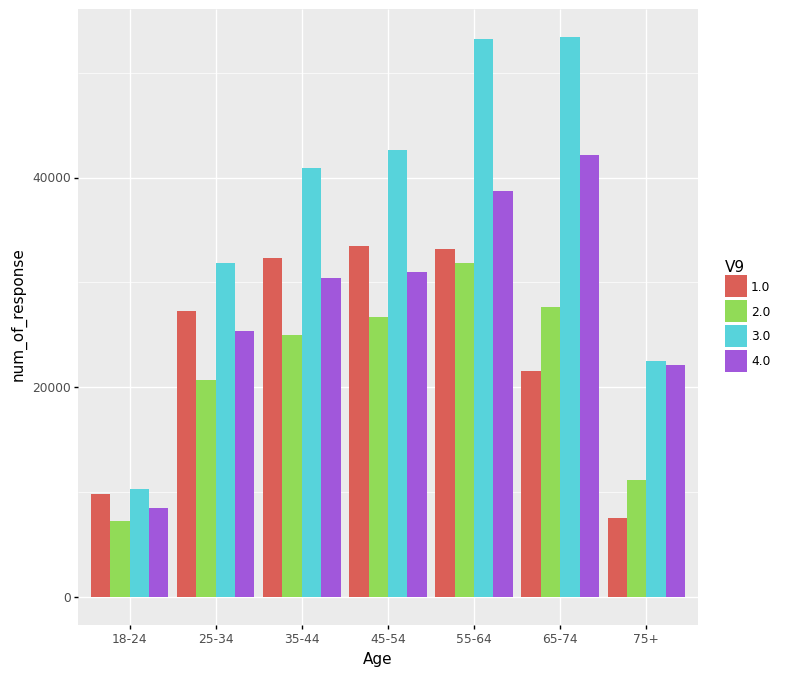

<ggplot: (8751869134968)>

In [252]:
(p9.ggplot(view, p9.aes(x='Age', y='num_of_response', fill='V9'))
 + p9.geom_col(stat='identity', position='dodge')
 + p9.theme(figure_size=(8, 8))
)  

In [220]:
# Get a quick view on the data
query = """
    SELECT a.state_name as State, s.age as Age, s.V9, s.num_of_response as num_of_responses
    FROM (SELECT A3b as State, D2 as age, V9, COUNT(*) as num_of_response
    FROM survey 
    WHERE wave = 7 AND State != "NaN" AND D2 != "NaN" AND V9 IS NOT NULL 
    GROUP BY A3b, D2, V9) s 
    INNER JOIN area a 
    WHERE s.State = a.state_id;
"""
view = pd.read_sql_query(query, engine)
view

,State,Age,V9,num_of_responses
0,Alabama,1.0,1.0,186
1,Alabama,1.0,2.0,108
2,Alabama,1.0,3.0,120
3,Alabama,1.0,4.0,80
4,Alabama,2.0,1.0,483
...,...,...,...,...
1475,Not in US,6.0,4.0,8
1476,Not in US,7.0,1.0,39
1477,Not in US,7.0,2.0,4
1478,Not in US,7.0,3.0,3
